In [5]:
import os
import torch.multiprocessing as mp
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

**Step 0 :** retrieve data and calculate embeddings (unable to precalculate and store due to disk quota limits)

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm

sentence_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
all_embeddings = []
df = pd.read_csv('../dataset/train_with_flashiness.csv')

for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    # Get embeddings using your existing method
    title = row['title']
    description = row['description']
    channel = row['channel']
    date = row['date']
    field_embeddings = sentence_encoder.encode([title, description, channel, date], convert_to_tensor=True)
    # Store them in numpy arrays
    all_embeddings.append(field_embeddings.cpu().numpy())
   

    


100%|██████████| 15482/15482 [01:02<00:00, 246.08it/s]


Then, we're going to use our regressor to remove the "average prediction" so that our topic encoder can more narrowly focuse on topic as variable that'll increase or decrease views.

In [18]:
# Transform targets, and store targets and embeddings in a dataframe
import numpy as np

all_targets = np.log1p(df['views'].values)
all_targets = (all_targets - np.mean(all_targets)) / np.std(all_targets)

regressor_df = pd.read_csv('../pure_regression/full_dataset_predictions.csv')
regressor_predictions = np.array(regressor_df['predicted_logn_views'].values)

all_targets = all_targets - regressor_predictions

df['targets'] = all_targets.tolist()
df['embeddings'] = all_embeddings

df.head()


,Unnamed: 0,id,channel,title,date,description,views,year,flashiness_raw,flashiness,targets,embeddings
0,0,--2s6hjGrm4,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI & VFX Breakdowns: ""Warzone"" - by Ramesh Th...",2020-12-15 05:00:01+00:00,"Check out this revealing VFX Breakdown ""Warzon...",12299,2020,0.962535,-0.084385,-10.075594,"[[-0.07760659, -0.001022775, -0.09010337, -0.0..."
1,1,--DnfroyKQ8,UC-1rx8j9Ggp8mp4uD0ZdEIA,"A Sci-Fi Short Film: ""Exit"" - by Ng King Kwan ...",2020-07-01 16:00:00+00:00,"TheCGBros Presents ""Exit"" by Ng King Kwan - Th...",7494,2020,0.781158,-1.156490,-10.250481,"[[-0.022426384, 0.05459995, -0.0177436, 0.0594..."
2,2,--aiU7VQKEw,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI 3D Animated Short: ""Lost Love"" - by Akash ...",2019-02-18 20:30:00+00:00,"TheCGBros Presents ""Lost Love"" by Akash Manack...",11831,2019,0.858997,-0.696390,-10.038415,"[[-0.11143896, 0.022581432, 0.016571341, -0.02..."
3,6,-0SrlZAvSVM,UCW6NyJ6oFLPTnx7iGRZXDDg,Jo Goes Hunting - Careful | Animated music vid...,2020-03-10 14:30:01+00:00,"On the borderless map of a magical planet, lit...",2248,2020,0.743281,-1.380382,-10.198911,"[[-0.021549331, 0.040397692, -0.0008517903, -0..."
4,10,-13Y2Pe7kFs,UC-1rx8j9Ggp8mp4uD0ZdEIA,"CGI VFX Breakdown: ""Logan (Wolverine): Digital...",2017-09-20 20:13:52+00:00,Check out this outstanding behind-the-scenes l...,113806,2017,1.176349,1.179456,-9.350310,"[[-0.08767335, -0.07205786, 0.027961658, -0.06..."


**Step 0.5 :** See the 'size' of the embeddings, make sure their all relatively similar (equal importance in the cross attention mechanism). 

Nevermind, they're all normalised 

**Step 1 :** Create dataloaders, with the following training hyper-parameters :

In [19]:
BATCH_SIZE = 128
NUM_WORKERS = 16
PRE_FETCH_FACTOR = 4

In [26]:
from meta_dataset import MetadataDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = MetadataDataset(train_df)
val_dataset = MetadataDataset(val_df)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PRE_FETCH_FACTOR, pin_memory=True, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PRE_FETCH_FACTOR, pin_memory=True, persistent_workers=True)

**Step 2 :** Instantiate model

In [27]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
from topic_model import MetadataRegressor
import torch

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = MetadataRegressor().to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss() #HuberLoss(delta=1.0)

# Callback function
train_losses = []
val_losses = []
batch_losses = []

def plot_losses():
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    
    # Plot batch losses
    plt.subplot(1, 2, 1)
    plt.plot(batch_losses)
    plt.title('Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot epoch losses
    plt.subplot(1, 3, 2)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training')
    plt.plot(epochs, val_losses, 'r-', label='Validation')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Using device: cuda


**Step 3 :** Training Loop

In [30]:
EPOCHS = 3000

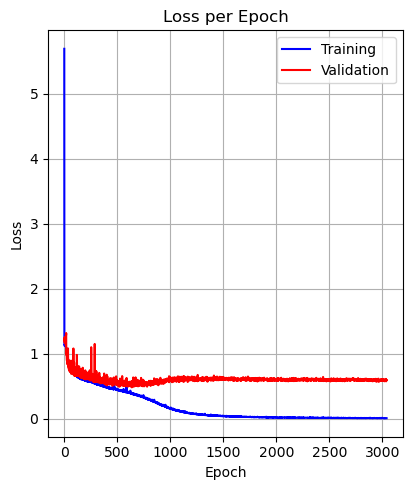

In [31]:
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    for i, (fields, targets) in enumerate(train_dataloader):
        fields = fields.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(fields)
        preds = preds.squeeze(-1) # Remove extra dimension
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        total_train_loss += loss.item() * len(fields)
        
        # Move tensors to CPU to free GPU memory
        fields = fields.cpu()
        targets = targets.cpu()
        
        
            
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for fields, targets in val_dataloader:
            fields = fields.to(device)
            targets = targets.to(device)
            
            outputs = model(fields)
            outputs = outputs.squeeze(-1) 
            val_loss = loss_fn(outputs, targets)
            total_val_loss += val_loss.item() * len(fields)
            
            # Move tensors to CPU to free GPU memory
            fields = fields.cpu()
            targets = targets.cpu()


    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataset)
    avg_val_loss = total_val_loss / len(val_dataset)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Free up memory
    torch.cuda.empty_cache()
    gc.collect()
    
    plot_losses()
    
plot_losses()

**Step 4 :** Save model

In [ ]:
torch.save(model.fusion.state_dict(), 'metadata_fusion.pth')
torch.save(model.regressor.state_dict(), 'metadata_regressor.pth')

**Step 5 :** Test performance

In [ ]:
# Optional : recreate the model
model = MetadataRegressor()
model.fusion.load_state_dict(torch.load('metadata_fusion.pth'))
model.regressor.load_state_dict(torch.load('metadata_regressor.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Evaluating: 100%|██████████| 25/25 [00:00<00:00, 442.75it/s]

Test Results:
MSE: 0.5919
RMSE: 0.7693
MAE: 0.5286
R²: 0.4773


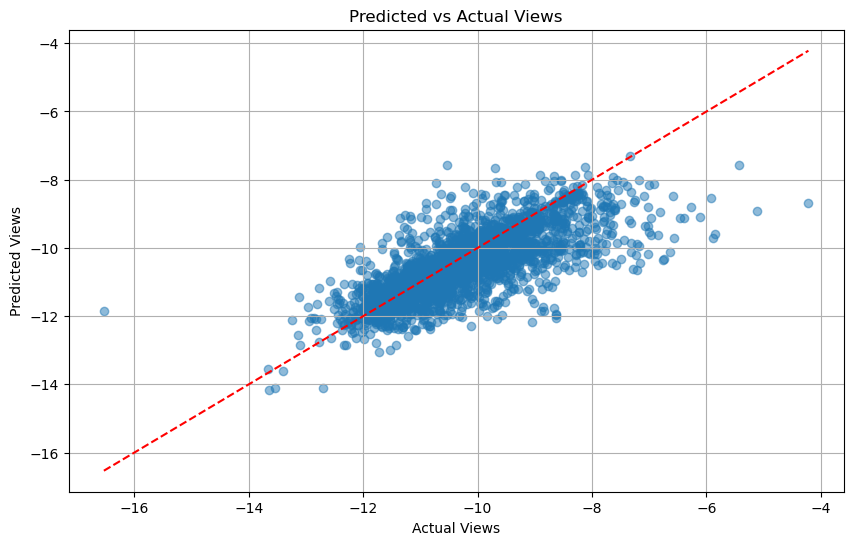

In [32]:
# Evaluation
model.eval()
predictions = []
actual = []
ids = []

with torch.no_grad():
    for fields, targets in tqdm(val_dataloader, desc="Evaluating"):
        fields = fields.to(device)
        outputs = model(fields)
        
        # Store predictions and ground truth
        predictions.extend(outputs.cpu().numpy().tolist())
        actual.extend(targets.numpy().tolist())

ids = val_df['id'].values.tolist()

# If we have actual flashiness values in the test set, calculate metrics
if "views" in val_df.columns:
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Actual Views')
    plt.ylabel('Predicted Views')
    plt.title('Predicted vs Actual Views')
    plt.grid(True)
    plt.show()

And on train dataset

Evaluating: 100%|██████████| 97/97 [00:00<00:00, 646.69it/s]


Test Results:
MSE: 0.0534
RMSE: 0.2311
MAE: 0.2175
R²: 0.9524


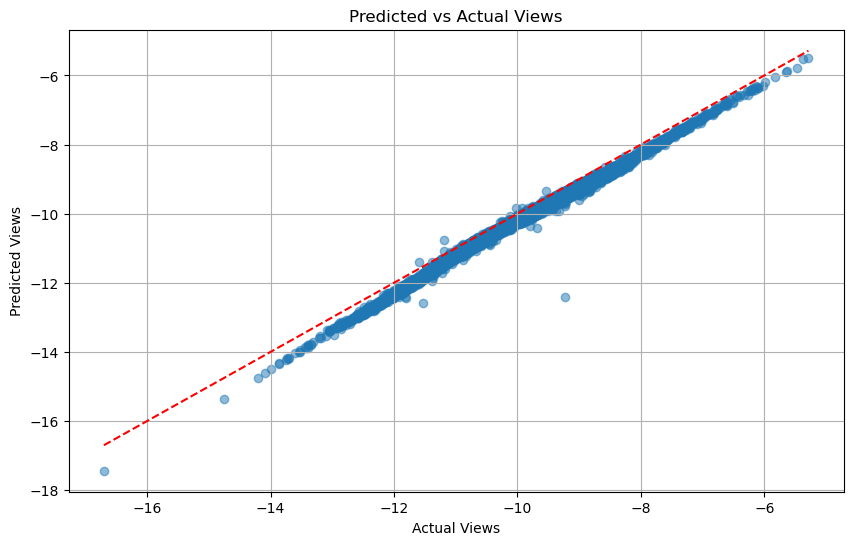

In [33]:
# Evaluation
model.eval()
predictions = []
actual = []
ids = []

with torch.no_grad():
    for fields, targets in tqdm(train_dataloader, desc="Evaluating"):
        fields = fields.to(device)
        outputs = model(fields)
        
        # Store predictions and ground truth
        predictions.extend(outputs.cpu().numpy().tolist())
        actual.extend(targets.numpy().tolist())

ids = train_df['id'].values.tolist()

# If we have actual flashiness values in the test set, calculate metrics
if "views" in val_df.columns:
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Actual Views')
    plt.ylabel('Predicted Views')
    plt.title('Predicted vs Actual Views')
    plt.grid(True)
    plt.show()

Okay, so we can see that with topic embedding, we're already doing slightly better than with a simple regressor. We are overfitting like crazy however